# Predicting median house value of a region

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.image as mpimg
import matplotlib.pyplot as graph
from pandas.plotting import scatter_matrix


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, Imputer, LabelBinarizer
from sklearn.model_selection import (GridSearchCV, train_test_split, 
                                     cross_val_score, cross_val_predict)

from Helpers.model_evaluation import plot_feature_importance, evaluate

graph.style.use('fivethirtyeight')

/home/harshil/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data and Visualize!

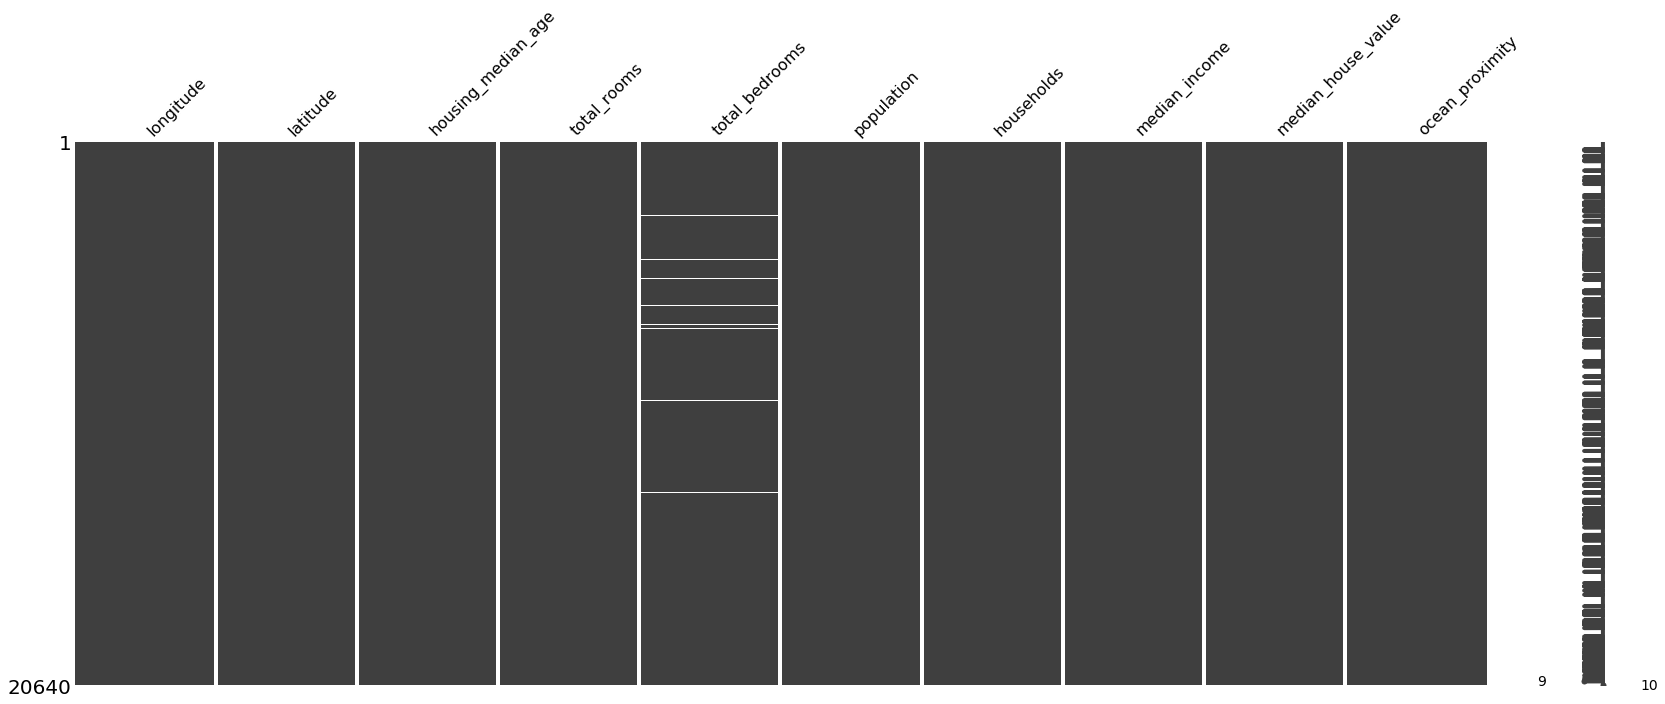

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv')

# Check for missing data
msno.matrix(df)
graph.show()

Total bedrooms are missing in some districts, we could drop these rows without losing too much. We could also make a model to predict those missing values but for now we will just impute the values.

In [3]:
# Make training and testing data
train_df, test_df = train_test_split(df, test_size=0.25)
print(train_df.shape, test_df.shape)

display(train_df.head())

(15480, 10) (5160, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6518,-118.01,34.07,24.0,5684.0,1485.0,6626.0,1481.0,2.2559,166800.0,INLAND
14457,-117.27,32.82,35.0,2908.0,595.0,1068.0,529.0,4.1793,500001.0,NEAR OCEAN
17077,-122.20,37.48,41.0,733.0,155.0,652.0,140.0,5.1654,233600.0,NEAR BAY
14366,-117.23,32.74,44.0,1404.0,229.0,513.0,217.0,4.1806,263800.0,NEAR OCEAN
2752,-115.40,32.70,19.0,583.0,113.0,531.0,134.0,1.6838,95800.0,INLAND


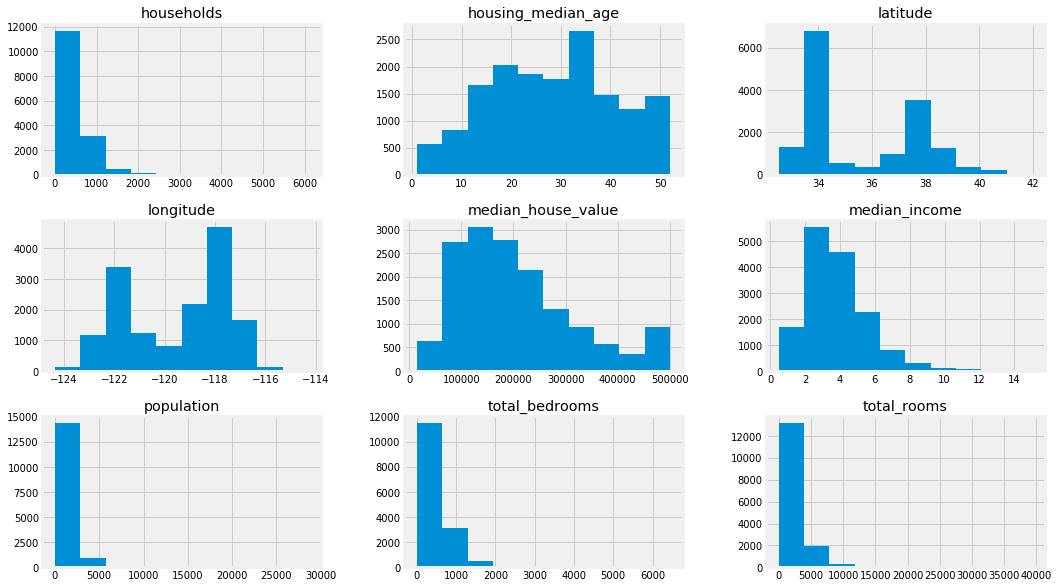

In [4]:
# Distribution of our numeric variables
train_df.hist(figsize=(16, 10))
graph.show()

Many of the variables are heavily skewed to the right. It will help to transform these variables. The range of our variables also vary a lot so standardizing them will be useful for certain models. 

Our outcome, the median house value is slightly skewed to the right some models may benefit from transforming this as well.

Median income doesn't seem to be in dollars, maybe they are grouped rankings? 

Longitude and Latitude bimodality makes me think the locations will be clustered, we can plot these to check. 

Featuer engineering may help, we can make variables such as number of rooms per household, population per household, number of bedrooms per room.

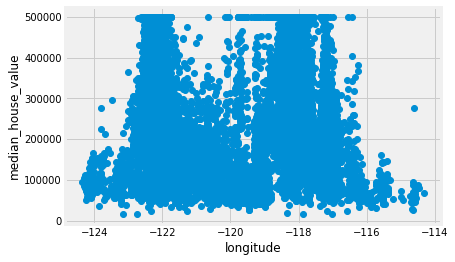

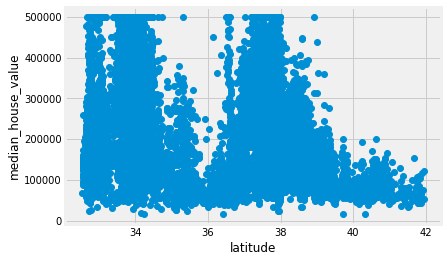

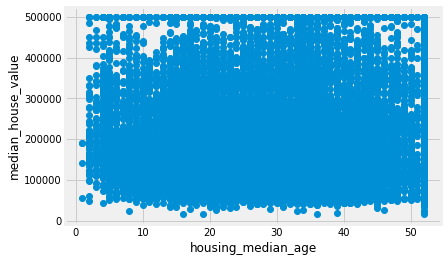

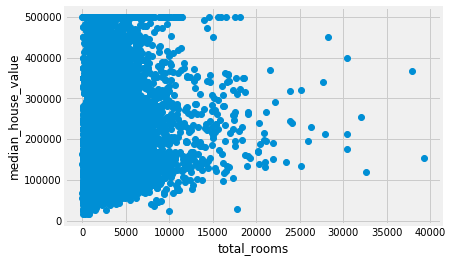

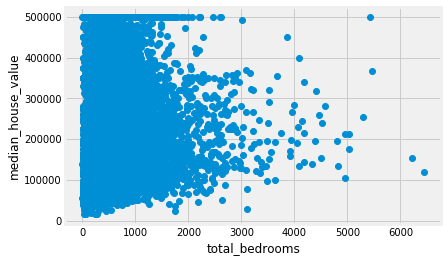

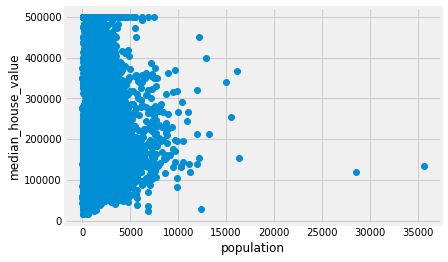

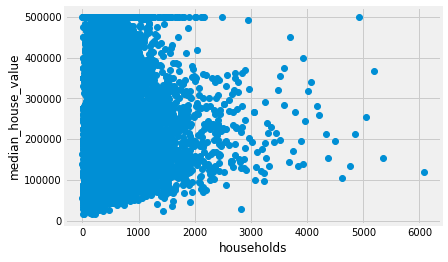

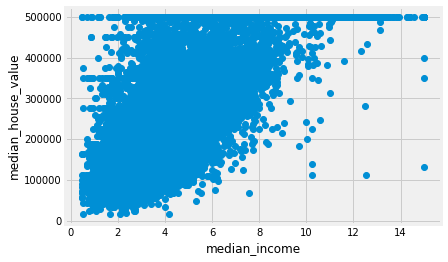

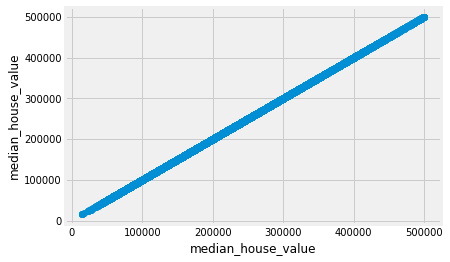

In [5]:
# Relation to median income
for num_col in train_df.select_dtypes(include=['int', 'float']):
    graph.plot(df[num_col], df['median_house_value'], 'o')
    graph.xlabel(num_col)
    graph.ylabel('median_house_value')
    graph.show()

median income of a district seems the most correlated with median house value but total rooms and bedrooms also seem to affect price. I am surprised how uninformative house age is on the price of a place, but I suppose houses don't depreciate. 

We are also seeing data quirks in the median house value data that wasn't captured in the distribution. It seems the value was capped at 500000 dollars, but there seems to be other values over represented as well around 350000 dollars and 250000 dollars (easiest to see in the median income vs median house value graph)

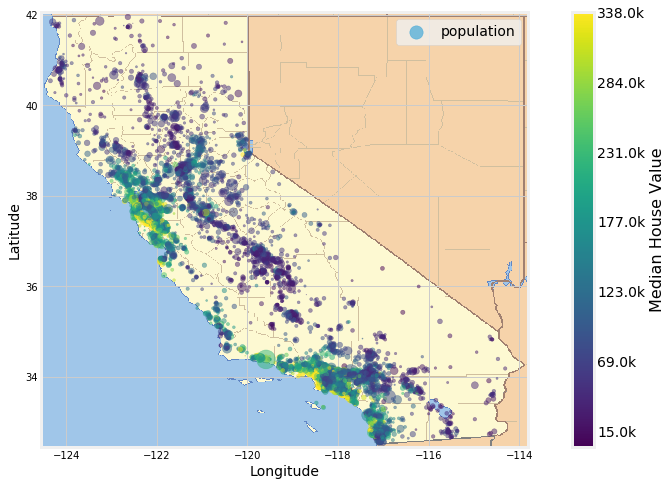

In [6]:
california_map = mpimg.imread('Data/california.png')

ax = train_df.plot(
    kind='scatter', 
    x='longitude', y='latitude', 
    c='median_house_value', cmap='viridis', colorbar=False, 
    s=df['population'] / 100, label='population', alpha=0.5,
    figsize=(14, 8), sharex=False
)

graph.imshow(california_map, extent=[-124.55, -113.80, 32.45, 42.05], cmap=graph.get_cmap('viridis'))

tick_values = np.linspace(train_df['median_house_value'].min(), train_df['median_house_value'].max(), 10)
cbar = graph.colorbar()
cbar.ax.set_yticklabels([f'{round(amount / 1000)}k' for amount in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

graph.ylabel("Latitude", fontsize=14)
graph.xlabel("Longitude", fontsize=14)
graph.legend(fontsize=14)
graph.show()

We can see the bimodality of the latitude and longitude variables now indeed there are two major clusters and a few minor ones. 

The house prices seem highest near the ocean so ocean proximity should be an interesting variable, lets graph it now.

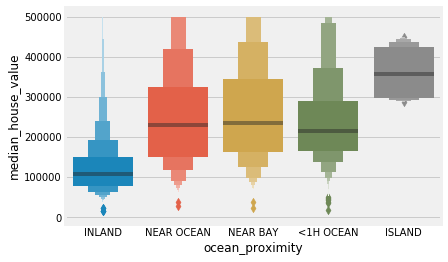

In [7]:
sns.boxenplot(x='ocean_proximity', y='median_house_value', data=train_df)
graph.show()

Indeed the inland houses have a lower price distribution, while houses near the bay, 1 hour from the ocean, near the ocean have higher price distributions. Although there are a few low priced house districts near the ocean. Island districts seem to have the highest house prices. 

# Preprocessing!

In [8]:
# Separate data into x and y

train_x = train_df.drop(labels=['median_house_value'], axis='columns')
train_y = train_df['median_house_value']

test_x = test_df.drop(labels=['median_house_value'], axis='columns')
test_y = test_df['median_house_value']

In [9]:
# Make the new columns mentioned above 


class NewFeatures(BaseEstimator, TransformerMixin):
    """
    Adds engineered features to X
    """
    def __init__(self, copy=True):
        self.copy = copy
        
    def fit(self, x):
        return self

    def transform(self, x):
        if self.copy is True:
            x = x.copy()
            
        x['room_per_house'] = x['total_rooms'] / x['households']
        x['bedrooms_per_room'] = x['total_bedrooms'] / x['total_rooms']
        x['pop_per_house'] = x['population'] / x['households']
        
        return x
    
    
class SubsetDf(BaseEstimator, TransformerMixin):
    def __init__(self, is_numerical=True):
        self.is_numerical = is_numerical
        
    def fit(self, x):
        return self
    
    def transform(self, x):
        if self.is_numerical is True:
            return x.select_dtypes(include=['int', 'float'])
        else:
            return x.select_dtypes(include=['object'])

num_pipeline = Pipeline([
    ('get_numerical_cols', SubsetDf(is_numerical=True)),
    ('add_features', NewFeatures()),
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

num_pipeline.fit(train_x)

num_train_x = num_pipeline.transform(train_x)
num_test_x = num_pipeline.transform(test_x)

In [10]:
# Categorical column
cat_train_x = SubsetDf(is_numerical=False).transform(train_x)
cat_test_x = SubsetDf(is_numerical=False).transform(test_x)

# One hot encode
binarizer = LabelBinarizer()
binarizer.fit(cat_train_x)

cat_train_x = binarizer.transform(cat_train_x)
cat_test_x = binarizer.transform(cat_test_x)

In [11]:
# Merge all features
train_all_x = np.concatenate([num_train_x, cat_train_x], axis=1)
test_all_x = np.concatenate([num_test_x, cat_test_x], axis=1)

# Training Models

### Linear Regression

In [12]:
# Train
lr = LinearRegression()
lr.fit(train_all_x, train_y)

train_pred_y = lr.predict(train_all_x)

lr_r2 = lr.score(train_all_x, train_y)
rmse = np.sqrt(mean_squared_error(train_pred_y, train_y))

# Training score error
print(f'R2: {lr.score(train_all_x, train_y)}')
print(f'RMSE: {np.sqrt(mean_squared_error(train_pred_y, train_y))}')

R2: 0.6547063732470308
RMSE: 67907.12734399625


That is a pretty good R squared, although r squared typically goes up the more features you have so may not be the best metric.

the root mean squared error tells us on average how much will the predicted price vary from the true price - 68112 dollars is a pretty big error. Let's try to improve our model but first lets use cross validation scorer to estimate the variance of the error. Let us also plot our predictions and residuals to better understand the model.

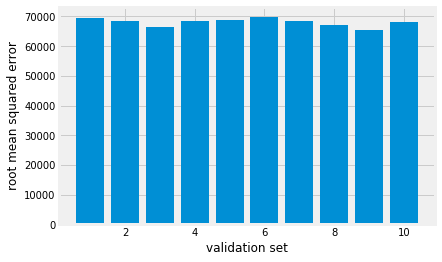

In [13]:
lr_scores = cross_val_score(LinearRegression(), 
                            train_all_x, train_y, 
                            scoring='neg_mean_squared_error',
                            cv=10
                           )
lr_scores = [np.sqrt(-score) for score in lr_scores]

graph.bar(range(1, 11), lr_scores)
graph.xlabel('validation set')
graph.ylabel('root mean squared error')
graph.show()

There isn't too much variance in the error using a linear regression

/home/harshil/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


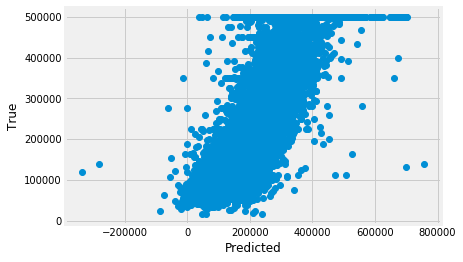

In [14]:
train_pred_y = cross_val_predict(LinearRegression(), train_all_x, train_y)

# Graph predictions vs true
graph.plot(train_pred_y, train_y, 'o')
graph.xlabel('Predicted')
graph.ylabel('True')
graph.show()

Very interesting! Some of the biggest errors come from the model predicting negative price values, since linear models extrapolate in all directions this is an easy problem to fix. 

A decision tree for example would not make this error since it depends on the average price of the training data at a leaf node, which will only be negative if there are negative prices in the training data. 

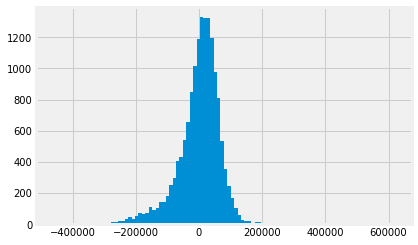

In [15]:
# Graph residuals
graph.hist(train_pred_y - train_y, bins=100)
graph.show()

The distribution of residuals seems slightly left skewed, so our model tends to underpredict the true price of houses.

### Random Forest

In [ ]:
rf_params = {
    'n_estimators': [1000, 1500, 2000],
    'max_depth': [2, 5, 10],
    'min_samples_split': [10, 30, 50],
            }
rf_model = GridSearchCV(
    estimator=RandomForestRegressor(oob_score=True),
    param_grid=rf_params,
    n_jobs=-1,
    cv=10,
)

rf_model.fit(train_all_x, train_y)

In [ ]:
rf_train_pred_y = rf_model.best_estimator_.predict(train_all_x)

print(f'R2: {rf_model.best_score_}')
print(f'RMSE: {np.sqrt(mean_squared_error(train_y, rf_train_pred_y))}')

In [ ]:
for params, score in zip(rf_model.cv_results_['params'], rf_model.cv_results_['mean_test_score']):
    print(params, score)

In [ ]:
graph.plot(rf_train_pred_y, train_y, 'o')
graph.xlabel('Predicted House Price')
graph.ylabel('True House Price')
graph.show()

As predicted the random forests predicitons do not go below zero, the results are pretty good

In [ ]:
graph.hist(rf_train_pred_y - train_y, bins=100)
graph.xlabel('Difference From True House Price')
graph.show()

The errors are slightly skewed to the left but they are much smaller than the regression model

# Feature Importance

In [ ]:
column_names = SubsetDf().transform(train_df).columns.tolist()
column_names += ['room_per_house', 'bedrooms_per_room', 'pop_per_house'] 
column_names += SubsetDf(is_numerical=False).transform(train_df).columns.tolist()

# Linear Regression coefficients
plot_feature_importance(column_names, lr.coef_, show_graph=False)
graph.title('Linear Regression Feature Importance')
graph.xlabel('Coef')
graph.show()

# Random Forest
plot_feature_importance(column_names, rf_model.best_estimator_.feature_importances_, show_graph=False)
graph.title('Random Forest Feature Importance')
graph.xlabel('Feature Importance')
graph.show()

First of all both models prioritize different variables. Interestingly the high coeficient total_rooms in the linear model is not important at all to the Random Forest. Median income on the other hand is highly valued by the Random Forest but not nearly so by the linear regression. They both seem to agree on the ocean proximity. The Linear regression seems to use the latitude and longitude a lot, maybe it would improve if these features were removed.

For the Random Forest median income alone is very predictive of the housing market. Ocean proximity as predicted from the map and boxenplot also is fairly predictive. Interestingly our derived feature of bedrooms_per_room is also pretty important. 
I wonder how a model would do with just these three features.

# Test Set Performance

In [ ]:
# Linear Regression model
print('Evaluating Linear Regression')
evaluate(lr, test_all_x, test_y, classification=False)
      
lr_pred_test_y = lr.predict(test_all_x)

graph.plot(lr_pred_test_y, test_y, 'o')
graph.title('LR Test Set Predictions')
graph.xlabel('Predicted House Price')
graph.ylabel('True House Price')
graph.show()

# Random Forest model
print('Evaluating Random Forest: ')
evaluate(rf_model, test_all_x, test_y, classification=False)
      
rf_pred_test_y = rf_model.predict(test_all_x)

graph.plot(rf_pred_test_y, test_y, 'o')
graph.title('RF Test Set Predictions')
graph.xlabel('Predicted House Price')
graph.ylabel('True House Price')
graph.show()

### Improved Linear Regression

Lets transform our variables and see how it affects the linear model

In [ ]:
train_df.hist(figsize=(10, 8))
graph.show()

In [ ]:
# Separate data into x and y
train_x = train_df.drop(labels=['median_house_value'], axis='columns')
train_y = train_df['median_house_value']

test_x = test_df.drop(labels=['median_house_value'], axis='columns')
test_y = test_df['median_house_value']

In [ ]:
class NewFeatures(BaseEstimator, TransformerMixin):
    """
    Adds engineered features to X
    """
    def __init__(self, copy=True):
        self.copy = copy
        
    def fit(self, x):
        return self

    def transform(self, x):
        if self.copy is True:
            x = x.copy()
        
        x['room_per_house'] = x['total_rooms'] / x['households']
        x['bedrooms_per_room'] = x['total_bedrooms'] / x['total_rooms']
        x['pop_per_house'] = x['population'] / x['households']
        
        log_transform_cols = [
            'households', 'population', 
            'total_bedrooms', 'total_rooms',
            'room_per_house', 'bedrooms_per_room', 'pop_per_house'
        ]
        
        for col in log_transform_cols:
            new_col_name = f'log_{col}'
            x[new_col_name] = np.log(x[col])
        
        x.drop(log_transform_cols, axis='columns', inplace=True)
        return x

num_pipeline = Pipeline([
    ('get_numerical_cols', SubsetDf(is_numerical=True)),
    ('add_features', NewFeatures()),
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

num_pipeline.fit(train_x)

num_train_x = num_pipeline.transform(train_x)
num_test_x = num_pipeline.transform(test_x)

In [ ]:
# Categorical column
cat_train_x = SubsetDf(is_numerical=False).transform(train_x)
cat_test_x = SubsetDf(is_numerical=False).transform(test_x)

# One hot encode
binarizer = LabelBinarizer()
binarizer.fit(cat_train_x)

cat_train_x = binarizer.transform(cat_train_x)
cat_test_x = binarizer.transform(cat_test_x)

In [ ]:
# Merge all features
train_all_x = np.concatenate([num_train_x, cat_train_x], axis=1)
test_all_x = np.concatenate([num_test_x, cat_test_x], axis=1)

In [ ]:
# Train
lr = LinearRegression()
lr.fit(train_all_x, train_y)

train_pred_y = lr.predict(train_all_x)

lr_r2 = lr.score(train_all_x, train_y)
rmse = np.sqrt(mean_squared_error(train_pred_y, train_y))

# Training score error
print(f'R2: {lr.score(train_all_x, train_y)}')
print(f'RMSE: {np.sqrt(mean_squared_error(train_pred_y, train_y))}')

In [ ]:
lr_scores = cross_val_score(LinearRegression(), 
                            train_all_x, train_y, 
                            scoring='neg_mean_squared_error',
                            cv=10
                           )
lr_scores = [np.sqrt(-score) for score in lr_scores]

graph.bar(range(1, 11), lr_scores)
graph.xlabel('validation set')
graph.ylabel('root mean squared error')
graph.show()

In [ ]:
train_pred_y = cross_val_predict(LinearRegression(), train_all_x, train_y)

# Graph predictions vs true
graph.plot(train_pred_y, train_y, 'o')
graph.xlabel('Predicted')
graph.ylabel('True')
graph.show()

The linear model only improved slightly from these changes